# Flux point fitting in Gammapy

In this tutorial we're going to learn how to fit spectral models to combined Fermi-LAT and IACT flux points.

The central class we're going to use for this example analysis is:  
- [gammapy.spectrum.FluxPointsFitter](http://astropy.readthedocs.io/en/latest/coordinates/index.html)


In addition we will work with the following data classes:

- [gammapy.spectrum.FluxPoints](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
- [gammapy.catalog.SourceCatalogGammaCat](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
- [gammapy.catalog.SourceCatalog3FHL](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
- [gammapy.catalog.SourceCatalog3FGL](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)

And the following spectral model classes:
- [PowerLaw](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
- [ExponentialCutoffPowerLaw](http://astropy.readthedocs.io/en/latest/coordinates/index.html)
- [LogParabola](http://astropy.readthedocs.io/en/latest/coordinates/index.html)







Let us start with the usual IPython notebook and Python imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from astropy import units as u
from astropy.table import vstack
from gammapy.spectrum.models import PowerLaw, ExponentialCutoffPowerLaw, LogParabola
from gammapy.spectrum.flux_point import FluxPointsFitter, FluxPoints, compute_flux_points_dnde
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogGammaCat, SourceCatalog3FHL

Next we instantiate the source catalogs so that we can access the data for the source we would like to analyse:

In [3]:
fermi_3fgl = SourceCatalog3FGL()
fermi_3fhl = SourceCatalog3FHL()
gammacat = SourceCatalogGammaCat()

## Data Preparation

For this analysis we choose to work with the source 'HESS J1507-622' and the associated Fermi-LAT sources '3FGL J1506.6-6219' and '3FHL J1507.9-6228e'. We access the data from the catalogs just by source name:

In [4]:
source_gammacat =  gammacat['HESS J1507-622']
source_fermi_3fgl = fermi_3fgl['3FGL J1506.6-6219']
source_fermi_3fhl = fermi_3fhl['3FHL J1507.9-6228e']

The corresponding flux points data can be accessed with `.flux_points` attribute:

In [5]:
flux_points_gammacat = source_gammacat.flux_points
flux_points_gammacat.table

e_ref,dnde,dnde_errn,dnde_errp
TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),1 / (cm2 s TeV)
float32,float32,float32,float32
0.8609,2.29119e-12,8.70543e-13,8.95502e-13
1.56151,6.98172e-13,2.20354e-13,2.30407e-13
2.76375,1.69062e-13,6.7587e-14,7.18838e-14
4.8916,7.72925e-14,2.40132e-14,2.60749e-14
9.98858,1.03253e-14,5.06315e-15,5.64195e-15
27.0403,7.44987e-16,5.72089e-16,7.25999e-16


For the Fermi-LAT sources we have to explicitely compute the differential flux points, because this information is not provided by the catalogs. For this we use the helper function [compute_flux_points_dnde](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.compute_flux_points_dnde.html#gammapy.spectrum.compute_flux_points_dnde), using the so called `'lafferty'` method:

In [6]:
flux_points_3fgl = compute_flux_points_dnde(flux_points=source_fermi_3fgl.flux_points,
                                            model=source_fermi_3fgl.spectral_model,
                                            method='lafferty')
flux_points_3fhl = compute_flux_points_dnde(flux_points=source_fermi_3fhl.flux_points,
                                            model=source_fermi_3fhl.spectral_model,
                                            method='lafferty')

Finally we stack the flux points into a single `FluxPoints` object and drop the upper limit values, because currently we can't handle them in the fit:

In [18]:
# stack flux point tables
flux_points = FluxPoints.stack([flux_points_gammacat, flux_points_3fhl, flux_points_3fgl])

# drop the flux upper limit values
flux_points = flux_points.drop_ul()

## Fitter Setup

We initialze the fitter object with the `'chi2assym'` statistic, because we have assymmetric errors on the flux points. As optimizer we choose the `'simplex'` algorithm and to estimate the errors we use `'cover'` method: 

In [19]:
fitter = FluxPointsFitter(stat='chi2assym', optimizer='simplex', error_estimator='covar')

## Powerlaw Fit

First we start with fitting a simple powerlaw to the data, which is described by the following formula:

$$
        \phi(E) = \phi_0 \cdot \left( \frac{E}{E_0} \right)^{-\Gamma}
$$

Where $\phi_0$ corresponds to `'amplitude'`, $E_0$ to `'reference'` and $\Gamma$ to the  `'index'` parameter:

In [9]:
pars = {}
pars['index'] = 2. * u.Unit('')
pars['amplitude'] = 1E-12 * u.Unit('cm-2 s-1 TeV-1')
pars['reference'] = 1. * u.TeV
pwl = PowerLaw(**pars)

After creating the model we run the fit by passing the `'flux_points'` and `'pwl'` objects:

In [20]:
result_pwl = fitter.run(flux_points, pwl)

As a quick check we print the value of the fit statistics per degrees of freedom:

In [21]:
print(result_pwl['statval/dof'])

2.58141475854


Finally we plot the data points and the best fit model:

(1e-13, 1e-11)

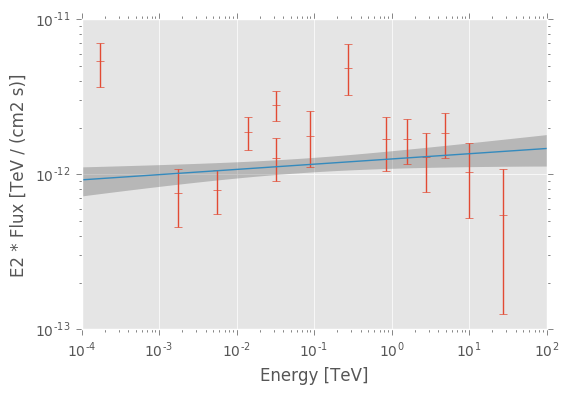

In [22]:
ax = flux_points.plot(energy_power=2)
result_pwl['best_fit_model'].plot(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2)
result_pwl['best_fit_model'].plot_error(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2)
ax.set_ylim(1E-13, 1E-11)

## Exponential Cut-Off Powerlaw Fit

In [12]:
pars = {}
pars['index'] = 2. * u.Unit('')
pars['amplitude'] = 1E-12 * u.Unit('cm-2 s-1 TeV-1')
pars['reference'] = 1. * u.TeV
pars['lambda_'] = 0. / u.TeV
ecpl = ExponentialCutoffPowerLaw(**pars)

In [13]:
result_ecpl = fitter.run(flux_points, ecpl)
print(result_ecpl['statval/dof'])

2.13132600203


(1e-13, 1e-11)

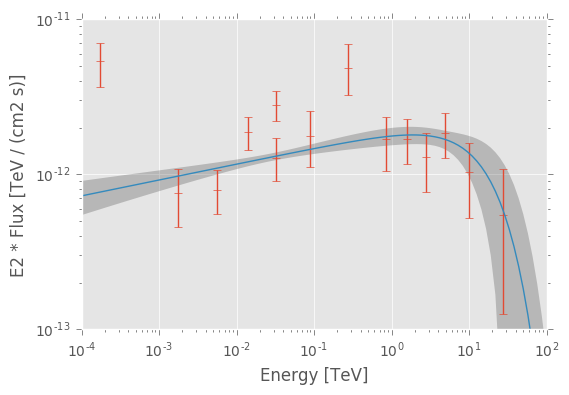

In [14]:
ax = flux_points.plot(energy_power=2)
result_ecpl['best_fit_model'].plot(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2)
result_ecpl['best_fit_model'].plot_error(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2)
ax.set_ylim(1E-13, 1E-11)

## Log-Parabola Fit

In [15]:
pars = {}
pars['alpha'] = 2. * u.Unit('')
pars['amplitude'] = 1E-12 * u.Unit('cm-2 s-1 TeV-1')
pars['reference'] = 1. * u.TeV
pars['beta'] = 0. * u.Unit('')
log_parabola = LogParabola(**pars)

In [16]:
result_log_parabola = fitter.run(flux_points, log_parabola)
print(result_log_parabola['statval/dof'])

1.83729480825


(1e-13, 1e-11)

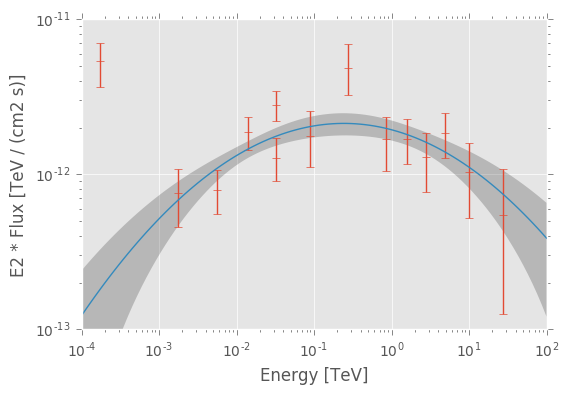

In [17]:
ax = flux_points.plot(energy_power=2)
result_log_parabola['best_fit_model'].plot(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2)
result_log_parabola['best_fit_model'].plot_error(energy_range=[1E-4, 1E2] * u.TeV, ax=ax, energy_power=2)
ax.set_ylim(1E-13, 1E-11)